In [ ]:
# default_exp xxsampler

# Sampler

> Collection of different samplers for sampling logical failure rates from quantum error correction protocols

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import make_hash, unpack, partition
from qsam.protocol import iterate
import qsam.callbacks as cb
from qsam.fault_generators import Depolarizing, to_ndarray

import numpy as np
import itertools as it
import functools
from tqdm.auto import tqdm # automatically choose jupyter tqdm version when available.

from anytree import RenderTree, NodeMixin
from anytree.exporter import JsonExporter
from anytree.importer import JsonImporter, DictImporter

In [ ]:
#export
class BaseSampler:
    
    def __init__(self, protocol, simulator, fault_gen, *args, **kwargs):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))
        
        fault_gen.configure(self.protocol._circuits)
        self.fault_gen = fault_gen
        
        self.setup(*args, **kwargs)
    
    def setup(self, *args, **kwargs):
        """Must be specified by child class."""
        pass
        
    def _verbose(self, local_vars):
        circuit = local_vars.get('circuit', None)
        fault_circuit = local_vars.get('fault_circuit', None)
        faults = local_vars.get('faults', None)
        node = local_vars.get('node', None)
        _node = local_vars.get('_node', None)
        msmt = local_vars.get('msmt', None)
        
        fs = [] if not circuit._noisy else [f'Tick {tick}: {fault_circuit[tick]}' for tick,_ in faults]
        if circuit_hash not in self.protocol._circuits.keys():
            print(f'Node {_node}, Circuit {circuit} -> {node}') # COR nodes
        else: # circuit nodes
            print(f'Node {_node}, faults {fs}, measured {msmt} -> {node}')

In [ ]:
#export
class Sampler(BaseSampler):
    
    def setup(self):
        n_p_phy = self.fault_gen.p_phy
        self.cnts = np.zeros( len(n_p_phy) )
        self.fail_cnts = np.zeros( len(n_p_phy) )
        
    def stats(self, p_idx=..., var_fn=math.Wilson_var):
        rate = self.fail_cnts[p_idx] / self.cnts[p_idx]
        var = var_fn(rate, self.cnts[p_idx])
        return rate, np.sqrt(var)
    
    def run(self, n_samples, callbacks=[], verbose=False):
        
        if not isinstance(callbacks, cb.CallbackList):
            callbacks = cb.CallbackList(sampler=self, callbacks=callbacks)       
        callbacks.on_sampler_begin()
                
        for i, p_phy in enumerate(tqdm(self.fault_gen.p_phy, desc='Total')):   
            self.stop_sampling = False
            self.p_idx = i
            
            for _ in tqdm(range(n_samples), desc=f'p_phy={",".join(list(f"{p:.2E}" for p in p_phy))}', leave=True):
                
                callbacks.on_sample_begin()

                sim = self.simulator(self.n_qubits)
                p_it = iterate(self.protocol)
                node = next(p_it)
                self.cnts[i] += 1
                
                while node:
                                        
                    if not self.protocol.out_edges(node):
                        self.fail_cnts[i] += 1
                        break
                    
                    circuit_hash, circuit = self.protocol.circuit_from_node(node)
                    if not circuit._noisy or circuit_hash not in self.protocol._circuits.keys():
                        msmt = sim.run(circuit)
                    else:
                        faults = self.fault_gen.faults_from_probs(p_phy, circuit_hash)
                        fault_circuit = self.fault_gen.gen_circuit(len(circuit), faults)
                        msmt = sim.run(circuit, fault_circuit)
                    _node = node
                    node = p_it.send(msmt)
                    
                    if verbose: self._verbose(locals())
                                    
                callbacks.on_sample_end()
                if self.stop_sampling: break
        
        callbacks.on_sampler_end()

We are going to test the direct Monte Carlo sampler on the simple GHZ state preparation flag circuit. 

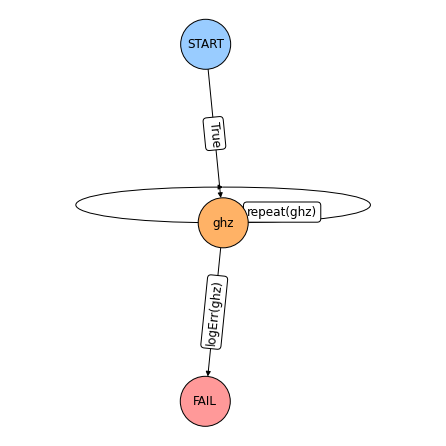

In [ ]:
from qsam.protocol import Protocol, draw_protocol
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ], ff_det=True)


def repeat(m):
    return len(m) < 3 and m[-1] == 1
    
def logErr(m):
    return len(m) >= 3 and m == [1,1,1]

functions = {'logErr': logErr, 'repeat': repeat}

g = Protocol()
g._check_fns.update(functions)
g.add_nodes_from(['ghz'], circuits=[ghz])

g.add_edge('START', 'ghz', check='True')

g.add_edge('ghz', 'ghz', check='repeat(ghz)')
g.add_edge('ghz', 'FAIL', check='logErr(ghz)')

draw_protocol(g, figsize=(6,6))

Total:   0%|          | 0/5 [00:00<?, ?it/s]

p_phy=1.00E-03:   0%|          | 0/500 [00:00<?, ?it/s]

p_phy=5.62E-03:   0%|          | 0/500 [00:00<?, ?it/s]

p_phy=3.16E-02:   0%|          | 0/500 [00:00<?, ?it/s]

p_phy=1.78E-01:   0%|          | 0/500 [00:00<?, ?it/s]

p_phy=1.00E+00:   0%|          | 0/500 [00:00<?, ?it/s]

Rel. std target of 0.5 reached. Sampling stopped.


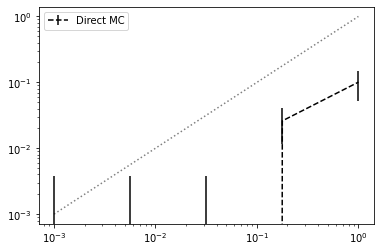

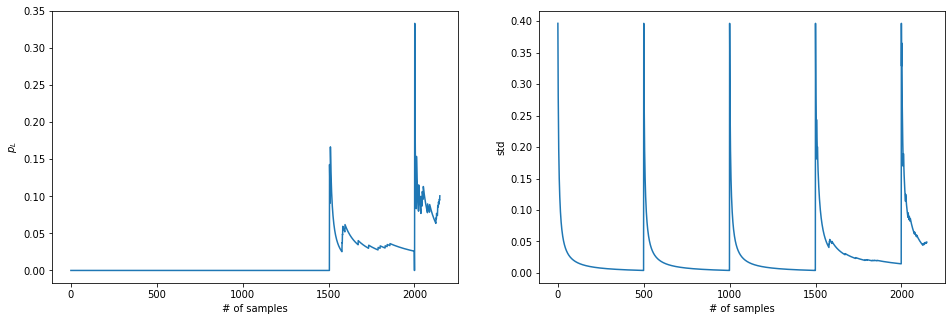

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator
from qsam.simulators.projectq import StateVectorSimulator

sample_range = np.logspace(-3,0,5)
err_params = {'p': sample_range}

fault_gen = Depolarizing(err_params)
sam = Sampler(g, ChpSimulator, fault_gen)
# sam = Sampler(g, StateVectorSimulator)

# sam.setup(sample_range, err_params)

callbacks = [
    cb.RelStdTarget(target=0.5),
    cb.PlotStats(sample_range),
    cb.StatsPerSample(),
    # cb.VerboseCircuitExec()
]

sam.run(n_samples=500, callbacks=callbacks)

In [ ]:
show_doc(Sampler)

<h2 id="Sampler" class="doc_header"><code>class</code> <code>Sampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Sampler</code>(**`protocol`**, **`simulator`**)



For the `SubsetSampler` we want to sample from specific fault-weight-subsets upto a certain maximum weight $w_{max}$. The benefit of this approach is that we can scale each of the resulting failure rates by analytically calculated `subset_occurances` for each `p_phy` which then gives us `p_L(p_phy)` for all `p_phy` without any additional sampling required. The subset sampler chooses the next fault-weight subset that is used when sampling from the next circuit in the protocol by the minimum sampled subset for a given circuit, which results in a balanced sampling over all subsets for a circuit. Additionally, one can exclude sampling for all circuits in a protocol from certain subsets by specifying a *list of ints* of `w_exclude` fault-weights. Overall, this approach of choosing the subsets and defining the weight threshold is not ideal. The dynamic subset sampler includes methods to improve on both of these points.

For subset sampling we need a new data structure to keep track of the circuit and circuit-subsets we are sampling from per protocol run. The natural structure for this problem is a Tree which we call `SampleTree`, populated with so-called `CountNodes`:

In [ ]:
#export
class CountNode(NodeMixin):
    def __init__(self, name, parent=None, children=None, counts=0, 
                 ckey=None, is_deterministic=False, is_fail=False):
        super(CountNode, self).__init__()
        
        self.name = name
        self.ckey = ckey
        self.counts = int(counts)
        self.is_deterministic = is_deterministic
        self.is_fail = is_fail
        
        self.parent = parent
        if children:
            self.children = children
            
    @property
    def rate(self):
        assert not self.ckey and not self.is_root
        if self.parent.counts == 0: return 0
        else: return self.counts / self.parent.counts

    @property
    def var(self, var_fn=math.Wilson_var):
        assert not self.ckey and not self.is_root
        if self.parent.counts == 0: return 1.0
        else: return var_fn(self.rate, self.parent.counts)
    
    def __str__(self):
        if self.is_root or self.ckey:
            return f'{self.name} ({self.counts})'
        else:
            return f'{self.name} ({self.counts}/{self.parent.counts}, {self.var:.2e})'

In [ ]:
#export
class SampleTree:
    def __init__(self, root=None):
        self.root = root
    
    def add(self, name, parent=None, **kwargs):
        if parent == None:
            if self.root == None:
                self.root = CountNode(name, **kwargs)
            return self.root
        else:
            child_match = [n for n in parent.children if n.name==name]
            if child_match: return child_match[0]
            else: return CountNode(name, parent=parent, **kwargs)
        
    def update(self, name, parent=None, **kwargs):
        node = self.add(name, parent, **kwargs)
        node.counts += 1
        return node
        
    def detach(self, node):
        node.parent = None
        
    def rate(self, const):
        """Calculate logical failure rate
        Sum of products of constants and rates along a path
        for every path leading to a fail.
        """
        p = 0
        for leaf in self.root.leaves:
            if not leaf.is_root and not leaf.parent.is_deterministic and leaf.is_fail: 
                prod = 1
                for n in leaf.path[1:]:
                    if n.ckey: prod *= const[n.ckey[0]][n.ckey[1]]
                    else: prod *= n.rate
                p += prod
        return p
    
    def delta(self, const):
        """Calculate the cutoff error (delta)
        Sum of products of constants and rates along a path
        for every path that has been sampled.
        """
        delta = 1.0
        for leaf in self.root.leaves:
            if not leaf.is_root:
                prod = 1.0
                for n in leaf.path[1:]:
                    if n.ckey: prod *= const[n.ckey[0]][n.ckey[1]]
                    else: prod *= n.rate
                delta -= prod
        return delta

    def var(self, const):
        """Calculate variance of logical failure rate
        Apply Gaussian error propagation to every differentiable node.
        All non-constant nodes are differentiable, as they contain a rate.
        """
        var = 0
        for node in [n for n in self.root.descendants if not n.ckey]: # all circuit nodes incl. None and Fail.
            if not node.parent.is_deterministic:
                
                twig = 1.0
                for n in node.path[1:-1]:
                    if n.ckey: twig *= const[n.ckey[0]][n.ckey[1]]
                    else: twig *= n.rate 
                
                if node.is_leaf and len(node.siblings) == 0:
                    var += node.var * twig**2 # count single None leaf nodes
                else:
                    subtree = 0
                    for leaf in node.leaves:
                        if not leaf.is_fail:  # No-Fail paths in subtree multiply to 0.
                            continue
                        prod = 1
                        for n in leaf.iter_path_reverse():
                            if n == node: break
                            elif n.ckey: prod *= const[n.ckey[0]][n.ckey[1]]
                            else: prod *= n.rate                
                        subtree += prod
                    var += node.var * twig**2 * subtree**2
        return var
    
    def delta_var(self, const):
        """Calculate the variance of the cutoff error (delta)
        Apply Gaussian error propagation to every sampled differentiable node.
        Fail/No-Fail branching can be ignored as it always sums to 1 here.
        """
        var = 0
        for node in [n for n in self.root.descendants if not n.ckey and not n.is_leaf]:
            if not node.parent.is_deterministic:
                twig = 1.0
                for n in node.path[1:-1]:
                    if n.ckey: twig *= const[n.ckey[0]][n.ckey[1]]
                    else: twig *= n.rate

                subtree = 0
                for leaf in node.leaves:
                    prod = 1
                    for n in leaf.iter_path_reverse():
                        if n == node: break
                        elif n.ckey: prod *= const[n.ckey[0]][n.ckey[1]]
                        else: prod *= n.rate                
                    subtree += prod
                var += node.var * twig**2 * subtree**2
        return var
    
    def __str__(self):
        return '\n'.join([f'{pre}{node}' for pre, _, node in RenderTree(self.root)])
    
    def display(self, fname='temp.png'):
        
        try:
            from anytree.exporter import UniqueDotExporter
            from IPython.display import Image, display ## ! requirements: jupyter, graphviz
        except ImportError as e:
            print(f"Cannot display tree due to missing libraries. Original error message {e}")
            return None
        
        def edgeattrfunc(node, child):
            weight = 10.0 * child.counts / self.root.counts
            if weight > 5.0:
                weight = 5.0
            elif weight < 0.2:
                weight = 0.2
            return f'penwidth="{weight}"'

        def nodeattrfunc(node):
            node_form = ""
            if node.is_fail: 
                node_form = ', style=filled, fillcolor="#ff9999"'
            return f'label="{node.name}"' + node_form

        img = UniqueDotExporter(self.root, 
                          edgeattrfunc=edgeattrfunc,
                          nodeattrfunc=nodeattrfunc).to_picture(fname)
        display(Image(fname))
        return fname
    
    def save(self, fname):
        exporter = JsonExporter(indent=2, sort_keys=False, default=str)
        with open(fname, 'w') as f:
            exporter.write(self.root, f)

    def load(self, fname):
        dictimporter = DictImporter(CountNode)
        importer = JsonImporter(dictimporter)
        with open(fname, 'r') as f:
            self.root = importer.read(f)
        return self

The subset sampler now keeps track of sampled nodes by altering the tree. As the tree is only created once a new sampler object is called, the sampling state is not lost after calling the `run()` method, which is particularly useful if one wants to continue sampling at a later point in time. Furthermore, a sampling tree can be saved to JSON and reloaded with the `tree.save` and `tree.load` functions.

Additionally, the subset sampler requires analytical functions to calculate subset occurences and functions for filtering and selecting subsets during sampling:

In [ ]:
#export
def circuit_partitions(circ, partition_names):
    return [partition(circ, GATE_GROUPS[name]) for name in partition_names]

In [ ]:
#export
def circuit_weight_vectors(w_max, w_exclude={}):
    w_exclude = set((w,) if isinstance(w, int) else w for w in w_exclude)
    w_maxs = [w_max] if isinstance(w_max, int) else w_max

    w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_maxs]
    w_vecs = list(it.product( *w_upto_w_maxs ))
    filtered_w_vecs = [w for w in w_vecs if w not in w_exclude]
    return filtered_w_vecs

In [ ]:
#export
def circuit_subset_occurence(partitions, partition_w_vecs, p_phy_per_partition):
    """Return (weight)x(p_phys) (parition) subset occurance matrix transforming p_SS vector to p_L vector"""
    n_partition_elems = np.array([len(p) for p in partitions])
    Aws = np.array([math.binom(w_vec, n_partition_elems, p_phy_per_partition) for w_vec in partition_w_vecs])
    Aws = np.product(Aws, axis=-1) # mult Aws for multi-parameter, i.e. multi-partitions
    return Aws

In [ ]:
#export
def protocol_partitions(circuits_dict, partition_names):
    return {c_hash: circuit_partitions(circ, partition_names)
           for c_hash, circ in circuits_dict.items() if circ._noisy}

In [ ]:
#export
def protocol_weight_vectors(partition_dict):
    return {c_hash: circuit_weight_vectors([len(p) for p in partitions]) 
            for c_hash, partitions in partition_dict.items()}

In [ ]:
#export
def protocol_subset_occurence(partition_dict, w_vecs_dict, p_phys):
    return {c_hash: circuit_subset_occurence(partition_dict[c_hash], w_vecs, p_phys)
            for c_hash, w_vecs in w_vecs_dict.items()}

In [ ]:
#export
def w_plus1_filter(sampler, w_ids, circuit_hash, **kwargs):
    n_Aws = np.ma.array(sampler.Aws_pmax[circuit_hash])
    n_Aws[w_ids,] = np.ma.masked # mask existing (already sampled) subsets
    w_ids.append(np.argmax(n_Aws)) # add next most important subset as possible candidate
    return w_ids

In [ ]:
#export
def random_sel(w_ids, **kwargs):
    return np.random.choice(w_ids)

In [ ]:
#export
def ERV_sel(self, sampler, w_ids, circuit_hash, tree_node, **kwargs):
    erv_deltas = []
    v_L = sampler.tree.var(sampler.Aws_pmax)
    delta = sampler.tree.delta(sampler.Aws_pmax)
    for idx in w_ids:
        w_vec = sampler.w_vecs[circuit_hash][idx]

        _tree_node = sampler.tree.add(w_vec, parent=tree_node, ckey=(circuit_hash, idx))
        __tree_node = sampler.tree.add('FAIL', parent=_tree_node, is_fail=True)
        _delta = sampler.tree.delta(sampler.Aws_pmax)
        _rate = __tree_node.rate

        _tree_node.counts += 1        
        v_L_minus = sampler.tree.var(sampler.Aws_pmax)

        __tree_node.counts += 1
        v_L_plus = sampler.tree.var(sampler.Aws_pmax)

        _v_L = _rate * v_L_plus + (1 - _rate) * v_L_minus
        erv_delta = np.abs(v_L - _v_L) + (delta - _delta) 
        # erv_delta = v_L - _v_L + (delta - _delta) # Check with new def of var
        erv_deltas.append( erv_delta )

        # revert the change
        _tree_node.counts -= 1
        __tree_node.counts -= 1
        if _tree_node.counts == 0: sampler.tree.detach(_tree_node)
        if __tree_node.counts == 0: sampler.tree.detach(__tree_node)
    
    idx = np.argmax(erv_deltas)
    return w_ids[idx]

In [ ]:
#export
class SubsetSampler(BaseSampler):
    """Subset Sampler of quantum protocols"""

    def setup(self, p_max):
        p_max = to_ndarray(p_max)
        assert len(p_max) == len(self.fault_gen.partition_names)
        
        self.tree = SampleTree()
        self.w_vecs = protocol_weight_vectors(self.fault_gen.partitions)
        self.Aws_pmax = protocol_subset_occurence(self.fault_gen.partitions, self.w_vecs, p_max)
        self.set_range()
        
    def set_range(self, err_params=None):
        if err_params: self.fault_gen.__init__(err_params)
        self.Aws = protocol_subset_occurence(self.fault_gen.partitions, self.w_vecs, self.fault_gen.p_phy)
        
    def stats(self, const='Aws', **kwargs):
        if const == 'Aws': Aws = self.Aws
        elif const == 'Aws_pmax': Aws = self.Aws_pmax
        v_L = self.tree.var(Aws)
        p_L = self.tree.rate(Aws)
        if isinstance(v_L, np.ndarray) and isinstance(p_L, int): 
            p_L = np.zeros_like(v_L)
        delta = self.tree.delta(Aws)
        delta_var = self.tree.delta_var(Aws)
        return p_L, np.sqrt(v_L), delta, np.sqrt(delta_var)
        
    def run(self, n_samples, callbacks=[], ss_filter_fn=w_plus1_filter, ss_sel_fn=ERV_sel, verbose=False):
        
        if not isinstance(callbacks, cb.CallbackList):
            callbacks = cb.CallbackList(sampler=self, callbacks=callbacks)
            
        self.stop_sampling = False        
        callbacks.on_sampler_begin()
        
        for i in tqdm(range(n_samples), desc='Total'):
            
            callbacks.on_sample_begin()
            
            sim = self.simulator(self.n_qubits)
            p_it = iterate(self.protocol)
            node = next(p_it)
            tree_node = None
            
            while True:
                                
                tree_node = self.tree.update(name=node, parent=tree_node)
                if node == None: break
                elif not self.protocol.out_edges(node): tree_node.is_fail = True; break
                
                circuit_hash, circuit = self.protocol.circuit_from_node(node)
                if circuit_hash not in self.protocol._circuits.keys() or not circuit._noisy: # correction circuits
                    msmt = sim.run(circuit)
                else:
                    w_ids = [n.ckey[1] for n in tree_node.children]
                    w_ids = ss_filter_fn(sampler=self, **locals())
                    w_idx = ss_sel_fn(sampler=self, **locals())
                    w_vec = self.w_vecs[circuit_hash][w_idx]
                    tree_node = self.tree.update(name=w_vec, parent=tree_node, ckey=(circuit_hash, w_idx),
                                                is_deterministic=True if circuit._ff_deterministic and not any(w_vec) else False)
                    faults = self.fault_gen.faults_from_weights(w_vec, circuit_hash)
                    fault_circuit = self.fault_gen.gen_circuit(len(circuit), faults)
                    msmt = sim.run(circuit, fault_circuit)
                
                _node = node
                node = p_it.send(msmt)
                
                if verbose: self._verbose(locals())
                    
            callbacks.on_sample_end()
            if self.stop_sampling: break
            
        callbacks.on_sampler_end()

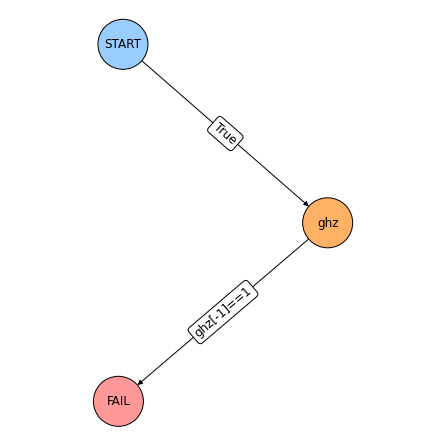

In [ ]:
from qsam.protocol import Protocol, draw_protocol
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ], ff_det=True)

p = Protocol()
p.add_nodes_from(['ghz'], circuits=[ghz])

p.add_edge('START', 'ghz', check='True')

p.add_edge('ghz', 'FAIL', check='ghz[-1]==1')

draw_protocol(p, figsize=(6,6))

Total:   0%|          | 0/100 [00:00<?, ?it/s]

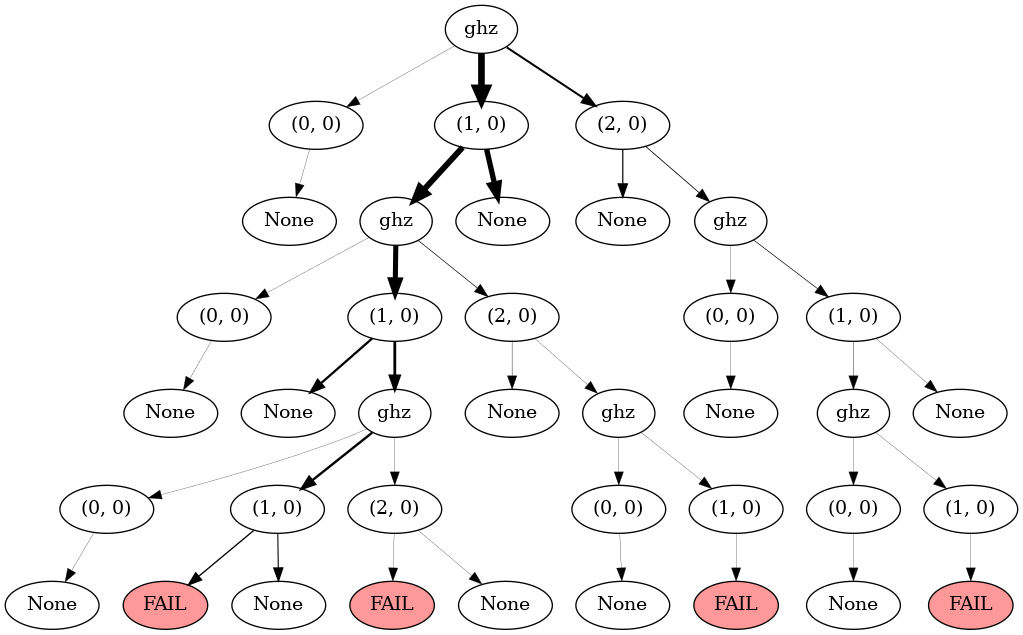

'temp.png'

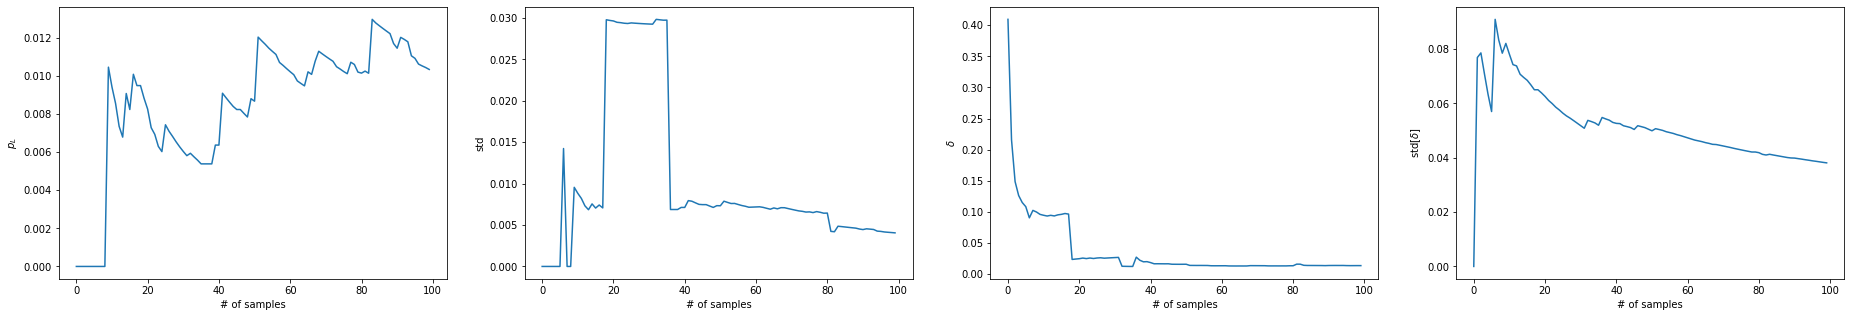

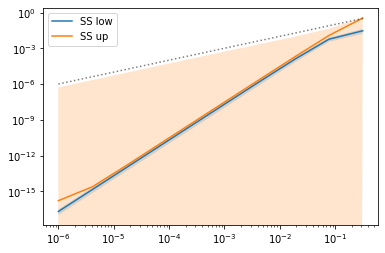

In [ ]:
#slow
from qsam.simulators.chp import ChpSimulator as CHP
# from qsam.simulators.projectq import StateVectorSimulator as SVS

sample_range = np.logspace(-6,-0.5,10)
err_params = {'p2': sample_range, 'm': 0.1}

fault_gen = Depolarizing(err_params)
sam = SubsetSampler(g, CHP, fault_gen, p_max=[0.1,0.1])

callbacks = [
    # cb.SubsetRates(fail_only=True),
    # cb.PathProducts(),
    cb.RelStdTarget(target=0.01),
    cb.StatsPerSample(),
    cb.PlotStats(sample_range), 
]
sam.run(100, callbacks=callbacks)#, ss_sel_fn=random_sel)
sam.tree.display()


In [ ]:
show_doc(SubsetSampler)

<h2 id="SubsetSampler" class="doc_header"><code>class</code> <code>SubsetSampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SubsetSampler</code>(**`protocol`**, **`simulator`**, **`fault_gen`**, **`p_max`**)

Subset Sampler of quantum protocols

# Multi-parameter/partition noise
It is more realistic to give the different partitions, i.e. 1-qubit or 2-qubit gates etc. different physical error rates. Similarly to the single-parameter case we can take a look at the occurance of the 2-partition-subsets:

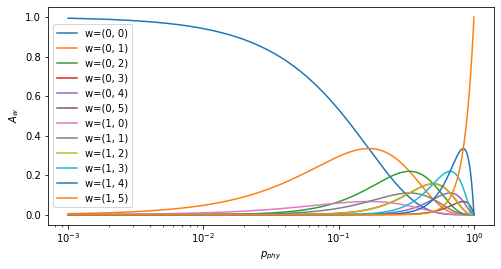

In [ ]:
#hide_input
#slow

from qsam.circuit import partition
from qsam.fault_generators import GATE_GROUPS
import itertools as it
from qsam.samplers.subset_helper import circuit_subset_occurence as subset_occurence
import matplotlib.pyplot as plt

n = 1000
p_phy = np.logspace(-3, 0, n)

err_params = {'p1':p_phy, 'p2':p_phy}
partitions = [partition(ghz, GATE_GROUPS[g]) for g in err_params.keys()]
p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions
w_max_vec = [len(p) for p in partitions]
w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_max_vec]
w_vecs = list(it.product( *w_upto_w_maxs ))
Aws = subset_occurence(partitions, w_vecs, p_phys_mat)

plt.figure(figsize=(8,4))
plt.plot(p_phy, Aws.T, label=[f'w={i}' for i in w_vecs]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

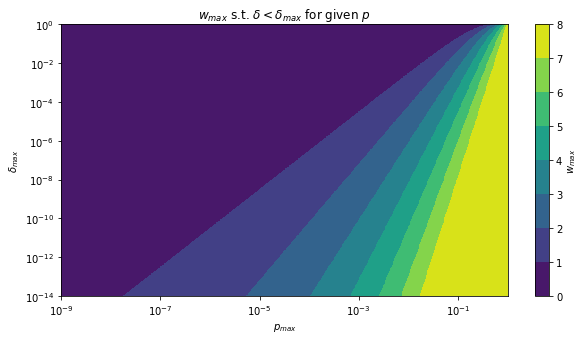

In [ ]:
#slow
#hide

def calc_w_max(p_max, delta_max, n_partition_elems):
    """Calculate weight cutoff at p_max for delta_max"""
    
    delta = 1
    for w_max in range(n_partition_elems+1):
        delta -= math.binom(w_max, n_partition_elems, p_max)
        if delta < delta_max: 
            break
    return w_max

n_gates = len(ghz)

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)

Z = [[calc_w_max(p_max, d_max, n_gates) for p_max in ps] for d_max in ds]

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{max}$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()